# <center> Day Vs Night Image Classifier </center>
---


### IDE & SW Used:
1. Python 3.7.6 
2. Anaconda3 (jupyter notebook)
3. Linux Ubuntu 20.04 Terminal

### SW Packages:
1. opencv-python 4.5.1.48
2. matplotlib 3.1.3
3. numpy 1.18.1 
4. glob2 0.7
5. jupyterlab 1.2.6


In [5]:
import os #you must always import it, because it is not a built-in function
import glob #for loading images from a directory
import matplotlib.image as mpimg #for reading & displaying images
import matplotlib.pyplot as plt #a collection of command style functions that make matplotlib work like MATLAB
import cv2 #import opencv-python library (a library designed to solve computer vision problems) 
import random #to get access to the random module, to get different random results
import numpy as np #an open-source numerical Python library, can be utilised to perform a number of mathematical operations on arrays

In [6]:
# Dataset directories
train_Dataset_dir = "images/train/"
test_Dataset_dir = "images/test/"

## Step 1: Load the datasets and visualize

In [7]:
'''This function loads in images and their labels and places them in a list
    im_list[0][:] will be the first image-label pair in the list'''
def load_dataset(image_dir):
# These first few lines of code will load the training day/night images and store all of them in a variable/list, IMAGE_LIST 
# This list contains the images and their associated label ("day" or "night"). 
    im_list = []
    image_types = ["day", "night"]
    
    # Iterate through each color folder
    for im_type in image_types:
        
        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")): # * allows an unspecified number of args and it consumes them all
            
            # Read in the image
            im = mpimg.imread(file)
            
            # Check if the image exists/if it's been correctly read-in
            if im is not None: #if im is not None == if not im is None  
                # Append the image, and it's type (red, green, yellow) to the image list
                im_list.append((im, im_type))
    
    return im_list

In [8]:
# Load training data
IMAGE_LIST = load_dataset(train_Dataset_dir)


## Step 2: Preprocess the data input images.

### 1. Resizing every image to a standard size

In [9]:
def standardize_input(image):
    
    # Resize image and pre-process so that all "standard" images are the same size
    standard_im = cv2.resize(image, (1100, 600))
    
    return standard_im

### 2. Encode the target variables

In [10]:
def encode(label):
    # encode day as 1, night as 0
    numerical_val = 0
    if(label == 'day'):
        numerical_val = 1
    
    return numerical_val

### This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and numerical labels.
#### 1. Resizing every image to a standard size
#### 2. Encode the target variables

In [11]:
def preprocess(image_list):
    
    #standardize and encode the input data
    standard_list = []
    
    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]
        
        # Standardize the image
        standardized_im = standardize_input(image)
        
        # Create a numerical label
        binary_label = encode(label)
        
        # Append the image, and it's one hot encoded label to the full, processed list of image data
        standard_list.append((standardized_im, binary_label))
    
    return standard_list

In [12]:
# Standardize all training images
STANDARDIZED_LIST = preprocess(IMAGE_LIST)

Shape: (600, 1100, 3)
Label [1 = day, 0 = night]: 1


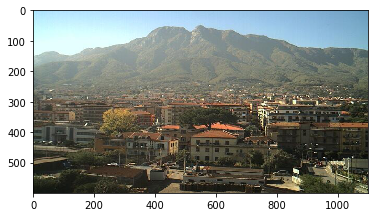

In [13]:
# Display a standardized image and its label

# Select an image by index
image_num = 0
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print("Label [1 = day, 0 = night]: " + str(selected_label))


## Step 3: Feature Extraction

Let's try to create a feature that represents the brightness in an image. We'll be extracting the **average brightness** using HSV colorspace. Specifically, we'll use the V channel (a measure of brightness), add up the pixel values in the V channel, then divide that sum by the area of the image to get the average Value of the image.


In [14]:
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])
    area = 600*1100.0  # pixels
    
    # find the avg
    avg = sum_brightness/area
    
    return avg

Avg brightness: 71.74480151515152


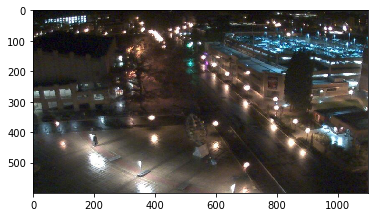

In [15]:
# Testing average brightness levels
# Look at a number of different day and night images and think about 
# what average brightness value separates the two types of images

# As an example, a "night" image is loaded in and its avg brightness is displayed
image_num = 190
test_im = STANDARDIZED_LIST[image_num][0]

avg = avg_brightness(test_im)
print('Avg brightness: ' + str(avg))
plt.imshow(test_im)

## Step 4: Build the classifier

We'll turn our average brightness feature into a classifier that takes in a standardized image and returns a `predicted_label` for that image. This `estimate_label` function should return a value: 0 or 1 (night or day, respectively).

In [16]:
# This function should take in RGB image input
def estimate_label(rgb_image, threshold):
    
    # Extract average brightness feature from an RGB image 
    avg = avg_brightness(rgb_image)
        
    # Use the avg brightness feature to predict a label (0, 1)
    predicted_label = 0
    #threshold = 120
    if(avg > threshold):
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1
    # else, the predicted_label can stay 0 (it is predicted to be "night")
    
    return predicted_label     
    

## Step 5: Evaluate the Classifier and Optimize

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook!
Below, we load in the test dataset, standardize it using the `standardize` function you defined above, and then **shuffle** it; this ensures that order will not play a role in testing accuracy.


In [17]:
# Load test data
TEST_IMAGE_LIST = load_dataset(test_Dataset_dir)

# Standardize the test data
STANDARDIZED_TEST_LIST = preprocess(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

In [18]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images, threshold):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im, threshold)

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels

In [19]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST, threshold=99)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.9375
Number of misclassified images = 10 out of 160


## Visualize the misclassified images
Visualize some of the images we classified wrong (in the MISCLASSIFIED list) and note any qualities that make them difficult to classify. This will help us identify any weaknesses in our classification algorithm.

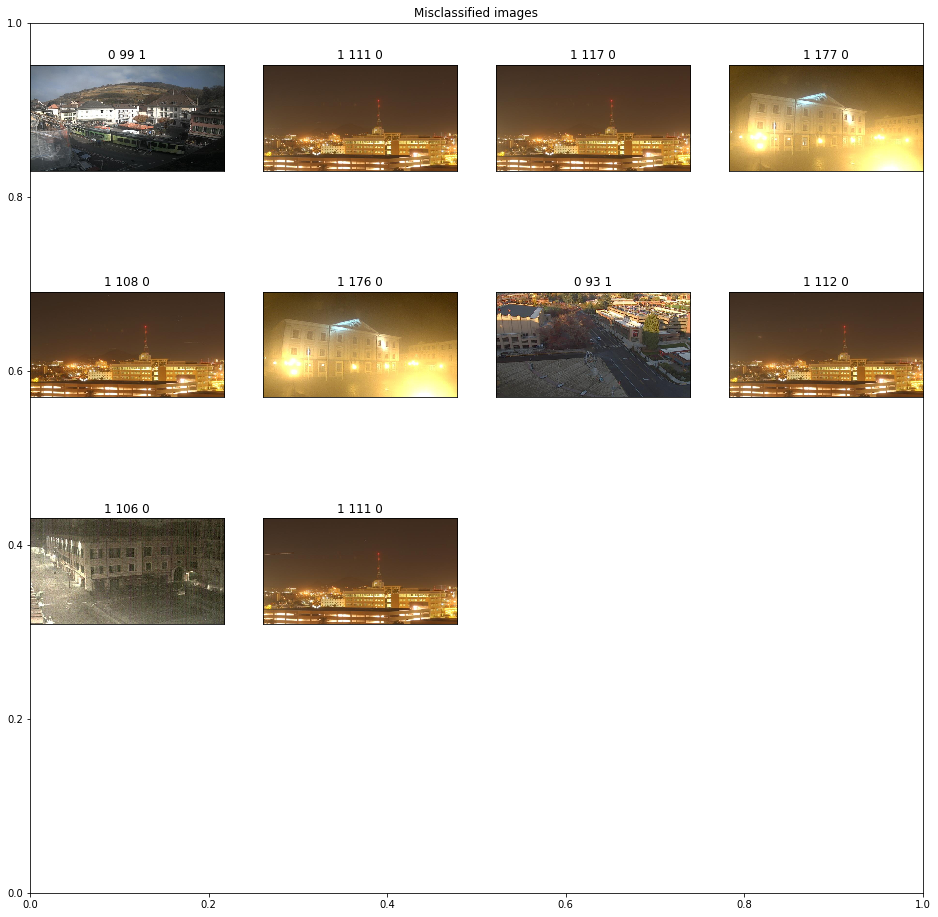

In [20]:
# Visualize misclassified example(s)
## TODO: Display an image in the `MISCLASSIFIED` list 
## TODO: Print out its predicted label - to see what the image *was* incorrectly classified as5
num = 0
test_mis_im = MISCLASSIFIED[num][0]

fig = plt.figure(figsize=(16,16))
plt.title("Misclassified images")
for index in range(len(MISCLASSIFIED)):
    ax = fig.add_subplot(4, 4, index + 1, xticks=[], yticks=[])
    image = MISCLASSIFIED[index][0]
    label_true = MISCLASSIFIED[index][1]
    label_guess = MISCLASSIFIED[index][2]
    bright = avg_brightness(image)
    ax.imshow(image)
    ax.set_title("{} {:0.0f} {}".format(label_true, bright, label_guess))
    
    if index==15:
        break


## Analyzing HSV
When visualizing the HSV channels you can detect very fast that all misqualified night images have a very low hue value which is caused by the artificial yellow lights. The value lays about in the region of < 30.

Day images on the other hand which are a far more common mix of all sorts of colors basically land at an average value in general far above 50.

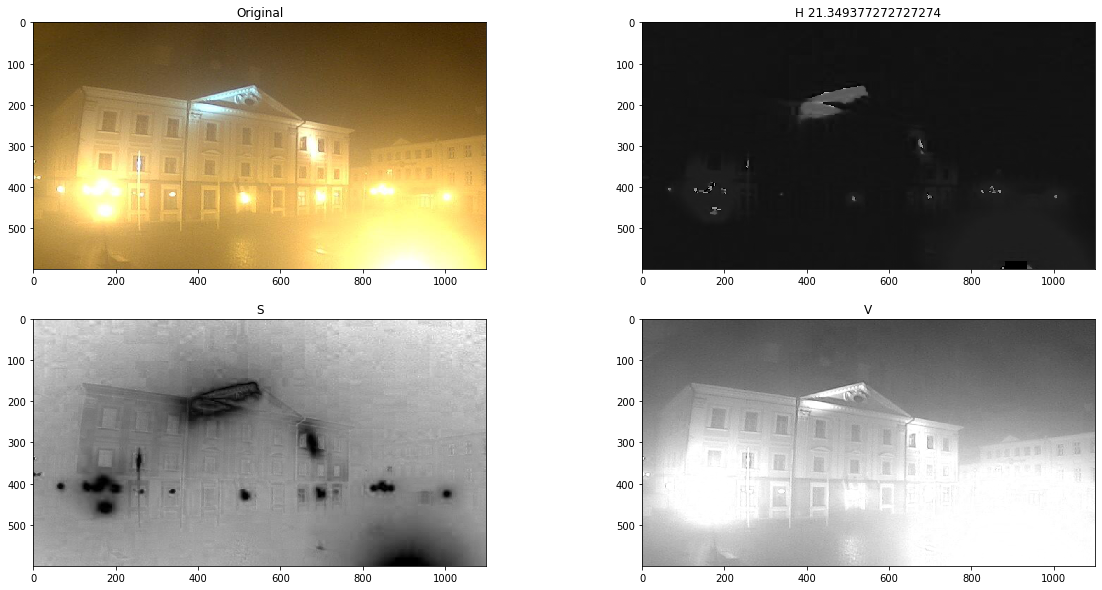

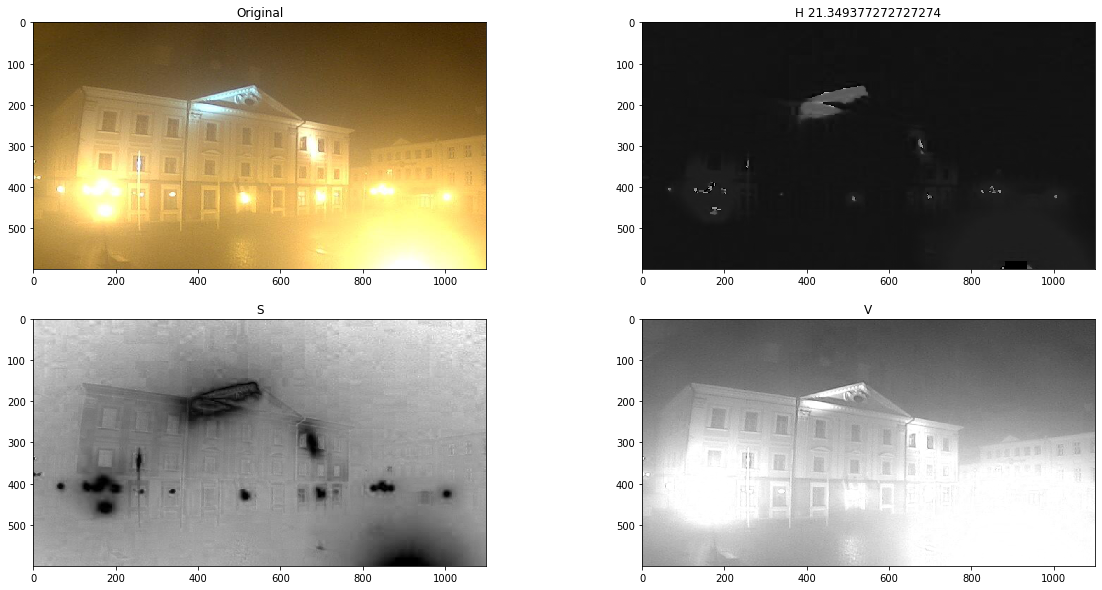

In [21]:
def display_artificial_lights(rgb_image):
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    cols = 2
    rows = 2
    
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    
    fig = plt.figure(figsize=(20,10))
    
    ax = fig.add_subplot(rows, cols, 1)
    ax.set_title("Original")
    ax.imshow(rgb_image)

    ax = fig.add_subplot(rows, cols, 2)
    ax.set_title("H {}".format(np.mean(h)))
    ax.imshow(h,cmap='gray', vmin=0, vmax=255)
    
    ax = fig.add_subplot(rows, cols, 3)
    ax.set_title("S")
    ax.imshow(s,cmap='gray', vmin=0, vmax=255)

    ax = fig.add_subplot(rows, cols, 4)
    ax.set_title("V")
    ax.imshow(v,cmap='gray', vmin=0, vmax=255)
    
    plt.show()

display_artificial_lights(MISCLASSIFIED[5][0])
display_artificial_lights(MISCLASSIFIED[5][0])

## Step6: Optimise to 100% accuracy
The following approach only looks at the upper part of the image and additionally takes the experience about hue values from above into account, so images with artificial bright lights will be flagged as night images.

In [22]:
threshold_with_hue = 26

# This function should take in RGB image input
def estimate_label_even_more_improved(rgb_image):
    rgb_image = rgb_image[:rgb_image.shape[0]//4,:,:]

    # Extract average brightness feature from an RGB image 
    avg = avg_brightness(rgb_image)
    
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    h = hsv[:,:,0]    
    
    avg_h = np.mean(h)
    
    # Use the avg brightness feature to predict a label (0, 1)
    predicted_label = 0
    if(avg > threshold_with_hue):
        # if the average brightness is above the threshold value, we classify it as "day"
        predicted_label = 1

    if(avg_h<40 and avg <= threshold_with_hue):
        predicted_label = 0
        
        # else, the predicted_label can stay 0 (it is predicted to be "night")
    
    return predicted_label    

# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images_even_more_improved(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label_even_more_improved(im)

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels

# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images_even_more_improved(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: {:0.0f}% '.format(accuracy*100))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 100% 
Number of misclassified images = 0 out of 160




# <center>Conclusion</center>
---

### <center>**100%** accuracy received by using only one feature extraction, i.e the average brightness of the image.</center>

# <center>References</center>
---

1. Pablo Rozas Larraondo, Iñaki Inza, Jose A. Lozano (2017). Automating weather forecasts based on convolutional networks. [Inspiring resource]
2. https://docs.opencv.org/3.4
3. https://www.pyimagesearch.com
4. https://machinelearningmastery.com
5. https://www.geeksforgeeks.org
6. https://medium.com
7. https://towardsdatascience.com
8. https://pythonprogramming.net
9. https://www.tutorialspoint.com
10. https://github.com [Inspiring coding resource]

*Note: All images come from the [AMOS dataset](http://cs.uky.edu/~jacobs/datasets/amos/) (Archive of Many Outdoor Scenes).*
